In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, Input, concatenate
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import glob

In [ ]:
!unzip train.zip
!unzip test-images.zip

In [ ]:
inputs = Input(shape=(1024,1024,3))

c1 = Conv2D(16,kernel_size=3,padding='same',activation='relu')(inputs)
c1 = Dropout(0)(c1)
c1 = Conv2D(16,kernel_size=3,padding='same',activation='relu')(c1)
p1 = MaxPooling2D((2,2))(c1)

c2 = Conv2D(32,kernel_size=3,padding='same',activation='relu')(p1)
c2 = Dropout(0)(c2)
c2 = Conv2D(32,kernel_size=3,padding='same',activation='relu')(c2)
p2 = MaxPooling2D((2,2))(c2)

c3 = Conv2D(64,kernel_size=3,padding='same',activation='relu')(p2)
c3 = Dropout(0)(c3)
c3 = Conv2D(16,kernel_size=3,padding='same',activation='relu')(c3)
p3 = MaxPooling2D((2,2))(c3)

c4 = Conv2D(128,kernel_size=3,padding='same',activation='relu')(p3)
c4 = Dropout(0)(c4)
c4 = Conv2D(128,kernel_size=3,padding='same',activation='relu')(c4)
p4 = MaxPooling2D((2,2))(c4)

c5 = Conv2D(256,kernel_size=3,padding='same',activation='relu')(p4)
c5 = Dropout(0)(c5)
c5 = Conv2D(256,kernel_size=3,padding='same',activation='relu')(c5)
p5 = MaxPooling2D((2,2))(c5)

c6 = Conv2D(512,kernel_size=3,padding='same',activation='relu')(p5)
c6 = Dropout(0)(c6)
c6 = Conv2D(512,kernel_size=3,padding='same',activation='relu')(c6)
p6 = MaxPooling2D((2,2))(c6)

u7 = Conv2DTranspose(256, kernel_size=2, strides=(2,2), padding='same', activation='relu')(c6)
u7 = concatenate([u7,c5])
c7 = Conv2D(256, kernel_size=3, activation='relu', padding='same')(u7)
c7 = Dropout(0)(c7)
c7 = Conv2D(256, kernel_size=3, activation='relu', padding='same')(c7)

u8 = Conv2DTranspose(128, kernel_size=2, strides=(2,2), padding='same', activation='relu')(c7)
u8 = concatenate([u8,c4])
c8 = Conv2D(128, kernel_size=3, activation='relu', padding='same')(u8)
c8 = Dropout(0)(c8)
c8 = Conv2D(128, kernel_size=3, activation='relu', padding='same')(c8)

u9 = Conv2DTranspose(64, kernel_size=2, strides=(2,2), padding='same', activation='relu')(c8)
u9 = concatenate([u9,c3])
c9 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(u9)
c9 = Dropout(0)(c9)
c9 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(c9)

u10 = Conv2DTranspose(32, kernel_size=2, strides=(2,2), padding='same', activation='relu')(c9)
u10 = concatenate([u10,c2])
c10 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(u10)
c10 = Dropout(0)(c10)
c10 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(c10)

u11 = Conv2DTranspose(16, kernel_size=2, strides=(2,2), padding='same', activation='relu')(c10)
u11 = concatenate([u11,c1])
c11 = Conv2D(16, kernel_size=3, activation='relu', padding='same')(u11)
c11 = Dropout(0)(c11)
c11 = Conv2D(16, kernel_size=3, activation='relu', padding='same')(c11)

outputs = Conv2D(5,(1,1),activation='softmax')(c11)

model = tf.keras.Model(inputs,outputs)

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])



In [ ]:
model.summary()
# model.load_weights('drive/My Drive/unet.h5')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1024, 1024, 1 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1024, 1024, 1 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1024, 1024, 1 2320        dropout[0][0]                    
______________________________________________________________________________________________

In [ ]:
def convert(img):
  label = np.zeros((1024,1024,5))
  for i in range(1024):
    for j in range(1024):
      if (img[i,j,:]==np.array([0.,0.,0.])).all():
        label[i,j,:] = [0,0,0,0,1]
      elif (img[i,j,:]==np.array([1.,0.,0.])).all():
        label[i,j,:] = [0,0,0,1,0]
      elif (img[i,j,:]==np.array([0.,1.,0.])).all():
        label[i,j,:] = [0,0,1,0,0]
      elif (img[i,j,:]==np.array([0.,0.,1.])).all():
        label[i,j,:] = [0,1,0,0,0]
      else:
        label[i,j,:] = [1,0,0,0,0]
  return label

In [ ]:
def pred_to_image(prediction):
  img = np.zeros((1024,1024,3))
  for i in range(1024):
    for j in range(1024):
      if (np.argmax(prediction[i,j,:])==4):
        img[i,j,:] = [0,0,0]
      elif (np.argmax(prediction[i,j,:])==3):
        img[i,j,:] = [1,0,0]
      elif (np.argmax(prediction[i,j,:])==2):
        img[i,j,:] = [0,1,0]
      elif (np.argmax(prediction[i,j,:])==1):
        img[i,j,:] = [0,0,1]
      else:
        img[i,j,:] = [1,1,0]
  return img

In [ ]:
X = []
filenames = glob.glob('train/images/*')
for file in filenames:
  img = load_img(file)
  img = img_to_array(img).astype('float')/255
  X.append(img)
X = np.array(X)

In [ ]:
y = []
filenames = glob.glob('train/labels/*')
for file in filenames:
  img = load_img(file)
  img = img_to_array(img).astype('float')/255
  y.append(convert(img))
y = np.array(y)

In [ ]:
def append_array(a1,a2):
  a2 = np.expand_dims(a2,0)
  return  np.concatenate((a1,a2),axis=0)

In [ ]:
for i in range(15):
  temp_X = X[i,:,:,:]
  temp_Y = y[i,:,:,:]
  X = append_array(X,np.flipud(temp_X))
  y = append_array(y,np.flipud(temp_Y))
  X = append_array(X,np.fliplr(temp_X))
  y = append_array(y,np.fliplr(temp_Y))

In [ ]:
print(X.shape)
print(y.shape)

(45, 1024, 1024, 3)
(45, 1024, 1024, 5)


In [ ]:
temp_X = []
temp_Y = []

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint('drive/My Drive/unet_trial2.h5',save_best_only=True),
             tf.keras.callbacks.ReduceLROnPlateau(patience=5,min_delta=0.001,min_lr=1e-5, factor=0.5),
             tf.keras.callbacks.EarlyStopping(min_delta=0.01,patience=20),
             ]

In [ ]:
history = model.fit(X,y,batch_size=2,epochs=100, validation_split=0.2, callbacks=callbacks)

In [ ]:
img = load_img('train/images/1.png')
img = img_to_array(img).astype('float')/255
heatmap = load_img('train/labels/1.png')
predictions = model.predict(np.expand_dims(img,axis=0))

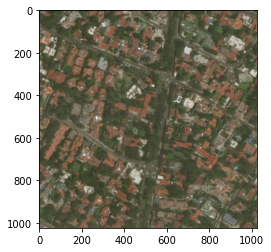

In [ ]:
plt.imshow(img)

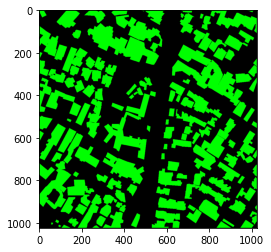

In [ ]:
plt.imshow(heatmap)

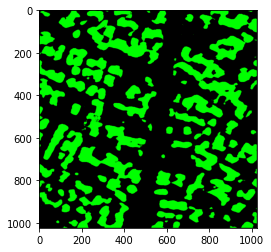

In [ ]:
plt.imshow(pred_to_image(predictions[0]))